In [1]:
import statistics
import numpy as np
import matplotlib.pyplot as plt
from math import exp, sqrt, log
from random import gauss, seed
import time
import math

In [2]:
from exchanges.coindesk import CoinDesk

start_date = '2017-09-01'

date_price_dict = CoinDesk().get_historical_data_as_dict(start = start_date, end = None)
price_vol_list = []
price_list = []
sorted_price_list = [(k,float(date_price_dict[k])) for k in sorted(date_price_dict.keys())]
for date_price_index in range(1, len(sorted_price_list)):
    price_vol_list.append(np.log(sorted_price_list[date_price_index][1] / sorted_price_list[date_price_index - 1][1]))

for date_price_index in range(1, len(sorted_price_list)):
    price_list.append(sorted_price_list[date_price_index][1])

sigma = statistics.stdev(price_vol_list)
S0 = sorted_price_list[-1][1]

In [3]:
K = 7500.0
T = 1.0
r = 0.02861
I = 100000

European Option Value: 281.617
Duration in Seconds (Method 1):  27.990
European Option Value: 282.916
Duration in Seconds (Method 2):   1.056


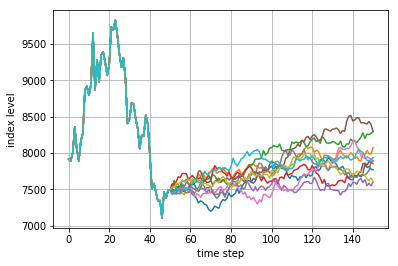

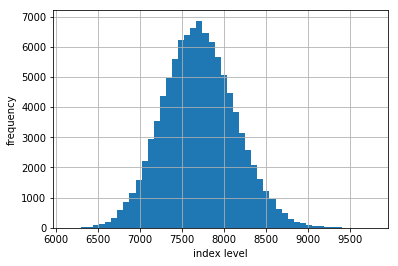

In [4]:
#Reference : https://github.com/kaushikb258/Black-Scholes-Merton/blob/master/PyMC.py

# number of time steps
M = 100

# time interval
dt = T / M

#--------------METHOD 1------------------------------------------

t0 = time.time()

S = []
for i in range(I):
    path = []
    for t in range(M+1):
        if t == 0:
            path.append(S0)
        else:
            z = gauss(0.0,1.0)
            St = path[t-1]*exp((r - 0.5 * sigma * sigma) * dt + sigma * sqrt(dt) * z)
            path.append(St)   
    S.append(path)   
    
C0 = exp( -r * T) * sum([max(path[-1] - K,0) for path in S]) / I


t1 = time.time()

time_to_compute = t1 - t0

print("European Option Value: %7.3f" % C0)
print("Duration in Seconds (Method 1): %7.3f" % time_to_compute)


#--------------METHOD 2------------------------------------------

t0 = time.time()

S = np.zeros((M+1, I))
S[0] = S0

for t in range(1, M+1):
    z = np.random.standard_normal(I)
    S[t] = S[t-1]*np.exp((r - 0.5 * sigma * sigma) * dt + sigma * math.sqrt(dt) * z)
history_price = np.ones((50,I))
last_index = 0
for price in price_list[-50:]:
    history_price[last_index] *= price
    last_index += 1
S = np.concatenate((history_price, S))

C0 = math.exp(-r * T) * np.sum(np.maximum(S[-1] - K, 0)) / I

t1 = time.time()

time_to_compute = t1 - t0

print("European Option Value: %7.3f" % C0)
print("Duration in Seconds (Method 2): %7.3f" % time_to_compute)



#------------------------------------------------------------------

plt.plot(S[:,:10])
plt.grid(True)
plt.xlabel('time step')
plt.ylabel('index level')
plt.show()

plt.hist(S[-1],bins = 50)
plt.grid(True)
plt.xlabel('index level')
plt.ylabel('frequency')
plt.show()

#------------------------------------------------------------------


In [5]:
#Reference : https://github.com/kaushikb258/Black-Scholes-Merton/blob/master/BSM.py
I = 100000 # number of simulations

z = np.random.randn(I)

# Values at maturity
ST = S0*np.exp((r - 0.5 * sigma * sigma) * T + sigma * np.sqrt(T) * z)
hT = np.maximum(ST - K, 0.0)
# Monte Carlo estimator
C0 = np.exp(-r * T) * np.sum(hT) / I
print("MC - Value of the European Call Option %5.3f" % C0)


MC - Value of the European Call Option 282.767


In [6]:
#Reference : https://github.com/jmiedwards/Python---Black-Scholes-Pricing-calculator-/blob/master/Black-Scholes%20Calculator%20Dividend.py
from scipy import stats

def black_scholes (cp, s, k, t, v, rf, div):
        """ 
        Price an option using the Black-Scholes model.
        s: initial stock price
        k: strike price
        t: expiration time
        v: volatility
        rf: risk-free rate
        div: dividend
        cp: +1/-1 for call/put
        """

        d1 = (math.log(s / k)+(rf - div + 0.5 * math.pow(v,2)) * t) / (v * math.sqrt(t))
        Nd1 = stats.norm.cdf(cp * d1)
        d2 = d1 - v*math.sqrt(t)
        Nd2 = stats.norm.cdf(cp * d2)
        optprice = (cp * s * Nd1) - (cp * k * math.exp( -rf * t) * Nd2)
        return optprice

print("BSM - Value of the European Call Option %5.3f" % black_scholes (+1, S0, K, T, sigma, r, 0))

BSM - Value of the European Call Option 282.102
